# Predicting surival of passengers on the Titanic:

### Notebook Set up

In [158]:
# import useful libraries
import numpy as np
import pandas as pd
import json

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

# Useful hack so variable value is printed even if its not on the last line of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [159]:
# load data
train_data = pd.read_csv("input/train.csv")
test_data = pd.read_csv("input/test.csv")

# train_data.head()
# test_data.head()

# # view statistics of data
# train_data.describe()
# test_data.describe()

# # view info of data
# train_data.info()
# test_data.info()

In [160]:
# Returns a concatenated df of training and test set
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

# Returns divided dfs of training and test set
def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

### Meet and Green Data

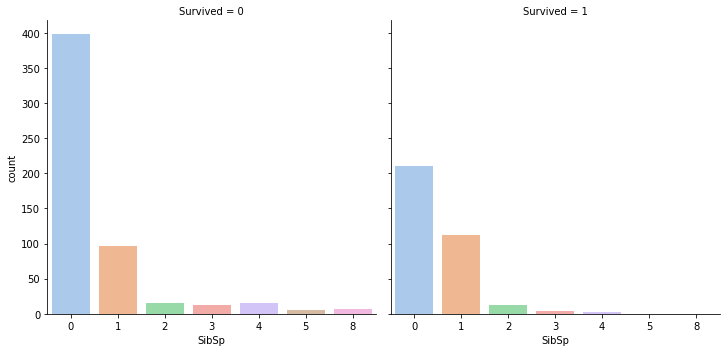

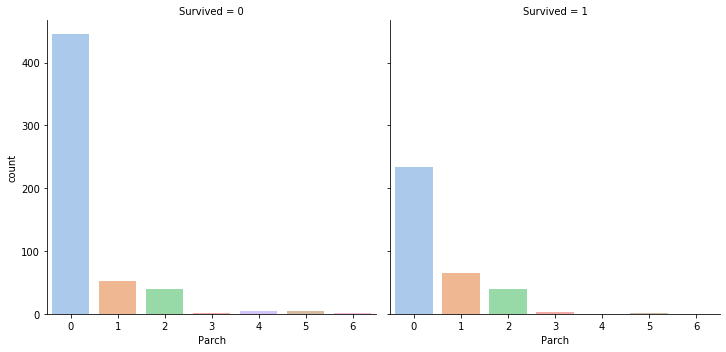

In [161]:
sns.catplot(x="SibSp", col = 'Survived', data=train_data, kind = 'count', palette='pastel')
sns.catplot(x="Parch", col = 'Survived', data=train_data, kind = 'count', palette='pastel')
plt.show()

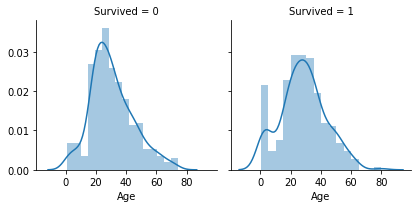

In [162]:
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Age")

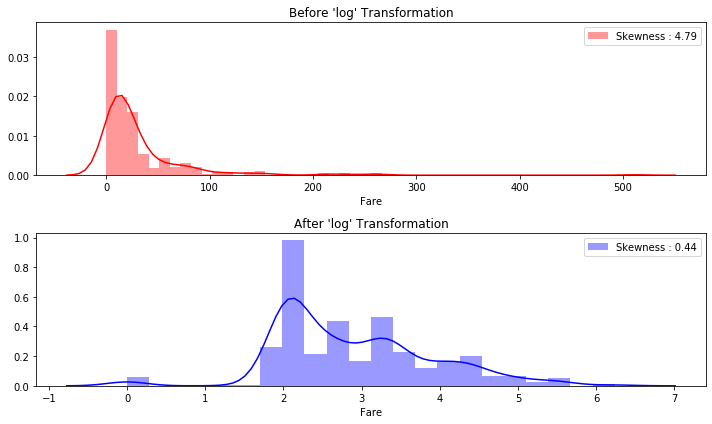

In [163]:
f, axes = plt.subplots(2, 1, figsize = (10, 6))

g1 = sns.distplot(train_data["Fare"], color="red", label="Skewness : %.2f"%(train_data["Fare"].skew()), ax=axes[0])
axes[0].title.set_text('Before \'log\' Transformation')
axes[0].legend()

log_fare = train_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

g2 = sns.distplot(log_fare, color="blue", label="Skewness : %.2f"%(log_fare.skew()), ax=axes[1])
axes[1].title.set_text('After \'log\' Transformation')
axes[1].legend()

plt.tight_layout()

In [164]:
# get correlations between features
df_train_corr = train_data.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = test_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

# Show high correlations
high_train_corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
high_test_corr = df_test_corr_nd['Correlation Coefficient'] > 0.1

df_train_corr_nd[high_train_corr]
df_test_corr_nd[high_test_corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Parch,SibSp,0.414838
10,Pclass,Age,0.369226
12,Survived,Pclass,0.338481
14,Age,SibSp,0.308247
16,Survived,Fare,0.257307
18,Fare,Parch,0.216225
20,Age,Parch,0.189119
22,SibSp,Fare,0.159651


,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577147
8,Pclass,Age,0.492143
10,Fare,Age,0.337932
12,Parch,SibSp,0.306895
14,Parch,Fare,0.230046
16,Fare,SibSp,0.171539


Text(0.5, 1, 'Training Set Correlations')

Text(0.5, 1, 'Test Set Correlations')

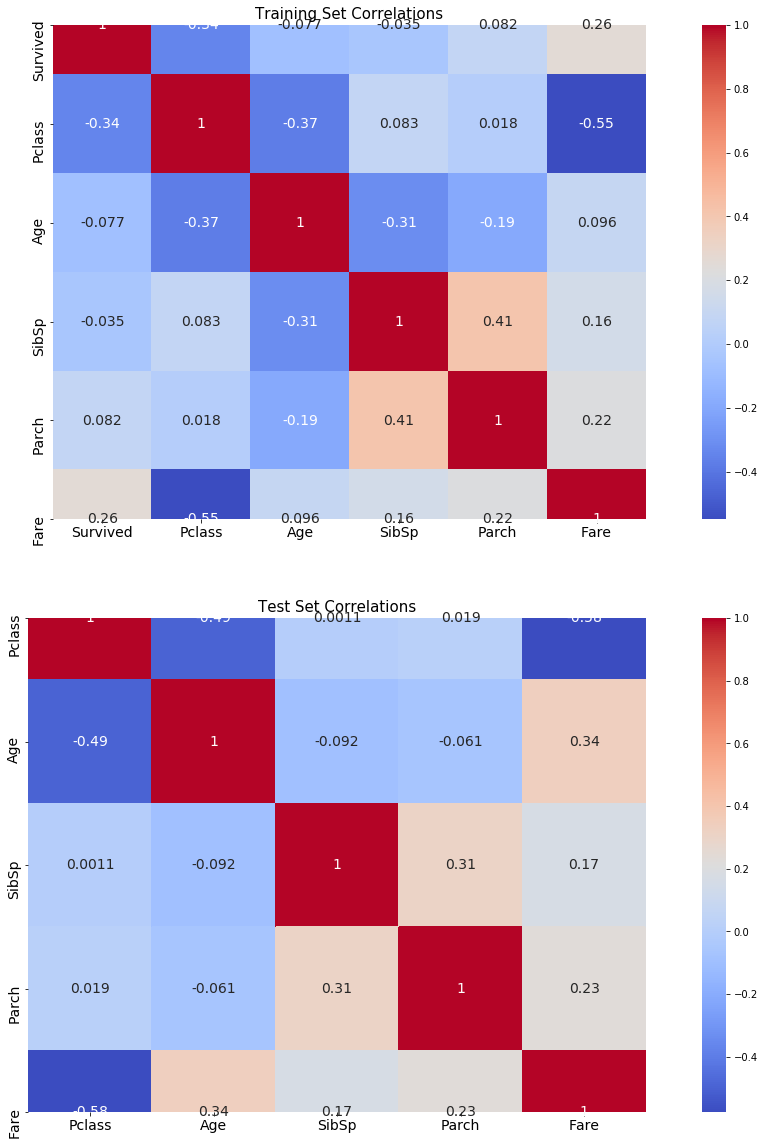

In [165]:
# see correlation heatmap 
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(train_data.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(test_data.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

In [166]:
# show number of missing values for each column
def display_missing(df):
    print('\n')
    for col in df.columns.tolist():         
        num_missing = df[col].isnull().sum()
        if num_missing > 0:
            print('{} column missing values: {}'.format(col, num_missing))

display_missing(train_data)
display_missing(test_data)



Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327


In [167]:
# complete missing data
all_data = concat_df(train_data, test_data)

all_data['Age'] = all_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
all_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace = True)
all_data['Fare'].fillna(train_data['Fare'].median(), inplace = True)

train_data, test_data = divide_df(all_data)
display_missing(train_data)
display_missing(test_data)



Cabin column missing values: 687


Cabin column missing values: 327


In [168]:
#feature_engineering

all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['IsAlone'] = 0
all_data.loc[all_data['FamilySize'] > 1, 'IsAlone'] = 1

all_data["FareLog"] = all_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
all_data['FareLogBin'] = pd.qcut(all_data['FareLog'], 13)
all_data['FareBin'] = pd.qcut(all_data['Fare'], 13)

all_data['AgeBin'] = pd.cut(all_data['Age'].astype(int), 10)
    
all_data['Title'] = all_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
title_names = (all_data['Title'].value_counts() < 10)
all_data['Title'] = all_data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

train_data, test_data = divide_df(all_data)

train_data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySize,IsAlone,FareLog,FareLogBin,FareBin,AgeBin,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,1,1.981001,"(-0.001, 1.981]","(-0.001, 7.25]","(16.0, 24.0]",Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,1,4.266662,"(4.034, 4.425]","(56.496, 83.475]","(32.0, 40.0]",Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,0,2.070022,"(2.066, 2.086]","(7.896, 8.05]","(24.0, 32.0]",Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,1,3.972177,"(3.529, 4.034]","(34.075, 56.496]","(32.0, 40.0]",Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,0,2.085672,"(2.066, 2.086]","(7.896, 8.05]","(32.0, 40.0]",Mr
5,25.0,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,1,0,2.135148,"(2.086, 2.351]","(8.05, 10.5]","(24.0, 32.0]",Mr
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1,0,3.948596,"(3.529, 4.034]","(34.075, 56.496]","(48.0, 56.0]",Mr
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,1,3.048088,"(2.756, 3.146]","(15.742, 23.25]","(-0.08, 8.0]",Master
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,3,1,2.409941,"(2.351, 2.565]","(10.5, 13.0]","(24.0, 32.0]",Mrs
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,2,1,3.403555,"(3.279, 3.529]","(26.55, 34.075]","(8.0, 16.0]",Mrs


In [169]:
#label encoding, scaling, feature selection, set up X and y
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# encode labels
non_numeric_features = ['AgeBin', 'FareBin', 'FareLogBin']
all_data = concat_df(train_data, test_data)
for feature in non_numeric_features:
    all_data[feature] = LabelEncoder().fit_transform(all_data[feature])
train_data, test_data = divide_df(all_data)


numerical_features = ["AgeBin", "FareBin", "IsAlone", "FamilySize", "Pclass"]
categorical_features = ["Sex", 'Embarked', 'Title']

X = train_data[numerical_features + categorical_features]
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_final_test = test_data[numerical_features + categorical_features]
X_final_test = pd.get_dummies(X_final_test, columns=categorical_features, drop_first=True)

y = train_data["Survived"]

# #Scale
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_final_test = scaler.transform(X_final_test)

print('X_train shape: {}'.format(X.shape))
print('y_train shape: {}'.format(y.shape))
print('X_test shape: {}'.format(X_final_test.shape))

X_train shape: (891, 12)
y_train shape: (891,)
X_test shape: (418, 12)


In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# define a cv_split
cv_split = model_selection.ShuffleSplit(n_splits = 6, test_size = .3, train_size = .7, random_state = 0)


# base model
base_model = RandomForestClassifier(random_state=0)
base_results = model_selection.cross_validate(base_model, X, y, cv=cv_split, return_train_score=True)

print("BEFORE Search - Training score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE Search - Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE Search - Test score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))


param_grid = {'n_estimators': [50, 100, 500, 1000],
               'criterion': ['gini'],
               'max_features': ['sqrt'],
               'max_depth': [5, 10, None], 
               'min_samples_split': [2, 4, 8, 11],
               'bootstrap': [True],
               'random_state': [0]
             }

grid_search = model_selection.GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, cv=cv_split, return_train_score=True, n_jobs=-1)
grid_search = grid_search.fit(X, y)

print('AFTER Search - Parameters: ', grid_search.best_params_)
print("AFTER Search - Training score mean: {:.2f}". format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_]*100)) 
print("AFTER Search - Test score mean: {:.2f}". format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]*100))
print("AFTER Search - Test score 3*std: +/- {:.2f}". format(grid_search.cv_results_['std_test_score'][grid_search.best_index_]*100*3))

BEFORE Search - Training score mean: 93.04
BEFORE Search - Test score mean: 82.09
BEFORE Search - Test score 3*std: +/- 6.23
AFTER Search - Parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 0}
AFTER Search - Training score mean: 90.48
AFTER Search - Test score mean: 83.58
AFTER Search - Test score 3*std: +/- 4.29


In [172]:
# train best model on all the data and make final predictions on test data
best_model = grid_search.best_estimator_
best_model = best_model.fit(X, y)

predictions = best_model.predict(X_final_test).astype(int)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)